<font size="+3"><strong>3.4. ARMA Models</strong></font>

In [1]:
# ------------------------------------------------------------
# 📊 Import Required Libraries
# ------------------------------------------------------------

# For tracking execution time
import time  

# To suppress warning messages
import warnings  

# For creating static plots
import matplotlib.pyplot as plt  

# For data manipulation and analysis
import pandas as pd  

# For interactive visualizations
import plotly.express as px  

# For statistical data visualizations
import seaborn as sns  

# For evaluating regression model performance
from sklearn.metrics import mean_absolute_error  

# For autocorrelation and partial autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  

# For ARIMA time series forecasting model
from statsmodels.tsa.arima.model import ARIMA  

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Prepare Data

## Import data

In [2]:
def wrangle(filepath):

    # Load CSV file and set 'timestamp' as the index
    df = pd.read_csv(filepath).set_index("timestamp")

    # Convert index to datetime format
    df.index = pd.to_datetime(df.index, errors="coerce", format="mixed")

    # Localize timestamps to UTC and convert to Africa/Nairobi timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove outlier P2 readings above 500
    df = df[df["P2"] < 500]

    # Resample data hourly, compute mean, and forward-fill missing values
    df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()

    # Return cleaned DataFrame
    return df


In [3]:
y = wrangle("../nairobi-city-air-quality.csv")
y.head()

,P2
timestamp,
2018-09-01 03:00:00+03:00,17.541667
2018-09-01 04:00:00+03:00,15.800000
2018-09-01 05:00:00+03:00,11.420000
2018-09-01 06:00:00+03:00,11.614167
2018-09-01 07:00:00+03:00,17.665000


In [4]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2018-09-01 03:00:00+03:00 to 2019-01-01 02:00:00+03:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P2      2928 non-null   float64
dtypes: float64(1)
memory usage: 45.8 KB


## Explore

### 🔁 Autocorrelation and Partial Autocorrelation Analysis

In this step, we explore the temporal dependencies in the PM 2.5 readings using **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots.

**Steps to perform:**

1. **Create an ACF Plot**
   - Use `plot_acf(y)` to visualize how each value in the time series correlates with its **past values (lags)**.
   - Label the axes clearly:
     - **x-axis:** "Lag [hours]"
     - **y-axis:** "Correlation Coefficient"

2. **Create a PACF Plot**
   - Use `plot_pacf(y)` to display the **direct correlation** between a data point and its lagged values, after controlling for the effects of shorter lags.
   - Label the axes the same way:
     - **x-axis:** "Lag [hours]"
     - **y-axis:** "Correlation Coefficient"

These plots help identify significant lag relationships in the time series — essential for selecting the appropriate number of lags in autoregressive (AR) models.


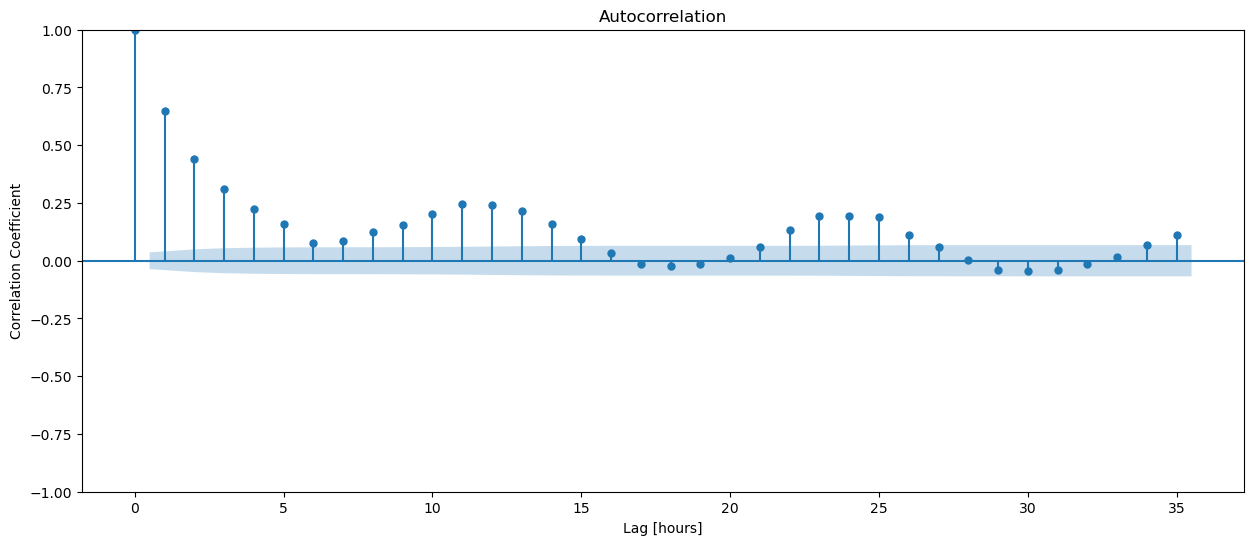

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

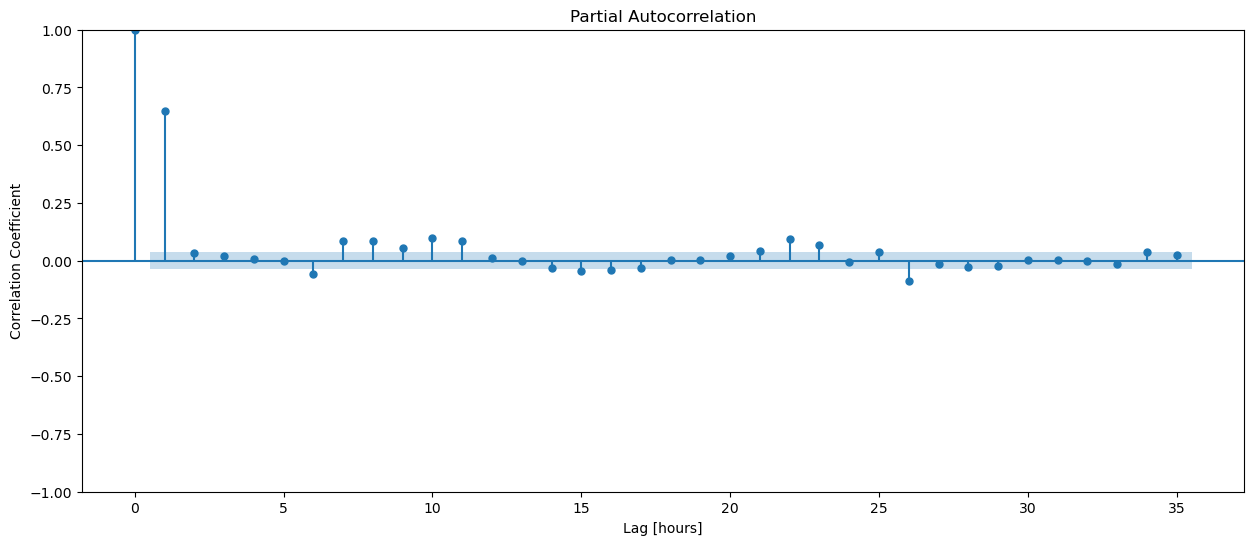

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

## Split

### Train-Test Split

Create a training set `y_train` that contains only readings from **October 2018**,  
and a test set `y_test` that contains readings from **November 1, 2018**.



In [5]:
mask1=y.index>="2018-10-01 00:00:00+03:00" 
mask2=y.index<"2018-11-01 00:00:00+03:00"
mask3=y.index>="2018-11-01 00:00:00+03:00" 
mask4=y.index<"2018-11-02 00:00:00+03:00"
y_train = y[mask1 & mask2]
y_test = y[mask3 & mask4]

# Build Model

## Baseline

### 📉 Calculate the Baseline Mean Absolute Error (MAE)

Before building a predictive model, we establish a **baseline** to measure our model’s improvement.

**Steps to perform:**

1. **Baseline Definition**  
   - Use a simple **naïve forecasting approach**, where each predicted value equals the **previous observation**.  
   - This represents a “do nothing” model that assumes no change from one time step to the next.

2. **Calculate the Baseline MAE**  
   - Compute the **Mean Absolute Error (MAE)** between the actual and predicted values.  
   - The MAE quantifies the average magnitude of prediction errors, regardless of direction.

3. **Purpose**  
   - The baseline MAE serves as a **benchmark** — your model should aim to achieve a **lower MAE** than this baseline to be considered effective.



In [6]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline,y_train)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: P2    10.12
dtype: float64
Baseline MAE: 4.17


## Iterate

### Hyperparameter Tuning for ARIMA Model

Create ranges for possible **p** and **q** values:
- `p_params` should range between **0 and 25**, with steps of **8**.  
- `q_params` should range between **0 and 3**, with steps of **1**.  

Then, complete the code to train an ARIMA model with **every combination** of hyperparameters in `p_params` and `q_params`.  
For each model:
1. Train the ARIMA model on the training data (`y_train`).
2. Predict on the test data (`y_test`).
3. Calculate the **Mean Absolute Error (MAE)**.
4. Store each MAE result in a dictionary for comparison.  



In [9]:
model = AutoReg(y_train,lags=26).fit()

In [7]:
p_params = range(0,25,8)
q_params =  range(0,3,1)

In [8]:
mae_grid={}
for p in p_params:
    mae_grid[p]=[]
    for q in q_params:
        order=(p,0,q)
        start_time=time.time()
        model=ARIMA(y_train,order=order).fit()
        elapsed_time=round(time.time()-start_time,2)
        print(f"Trained ARIMA model {order} in {elapsed_time} seconds")
        y_pred=model.predict()
        mae=mean_absolute_error(y_train,y_pred)
        mae_grid[p].append(mae)

Trained ARIMA model (0, 0, 0) in 0.31 seconds
Trained ARIMA model (0, 0, 1) in 0.13 seconds
Trained ARIMA model (0, 0, 2) in 0.18 seconds
Trained ARIMA model (8, 0, 0) in 0.53 seconds
Trained ARIMA model (8, 0, 1) in 1.69 seconds
Trained ARIMA model (8, 0, 2) in 3.02 seconds
Trained ARIMA model (16, 0, 0) in 1.29 seconds
Trained ARIMA model (16, 0, 1) in 3.68 seconds
Trained ARIMA model (16, 0, 2) in 6.04 seconds
Trained ARIMA model (24, 0, 0) in 5.17 seconds
Trained ARIMA model (24, 0, 1) in 6.27 seconds
Trained ARIMA model (24, 0, 2) in 11.96 seconds


### Organizing and Visualizing Model Performance

1. **Organize the MAE values**  
   Store all the Mean Absolute Error (MAE) values from the previous step in a DataFrame named `mae_df`.  
   - Each **row** should represent a possible value for **p**.  
   - Each **column** should represent a possible value for **q**.  

2. **Visualize the results**  
   Create a **heatmap** of the values in `mae_df` to easily compare performance across parameter combinations.  
   - Label the **x-axis** as `"p values"`.  
   - Label the **y-axis** as `"q values"`.  

This will help you quickly identify which combination of `p` and `q` produces the lowest MAE and therefore the best model performance.



In [9]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,4.1715,2.9384,2.9201,2.9144
1,3.3506,2.9149,2.9294,2.9136
2,3.1057,2.9164,2.9143,2.8979


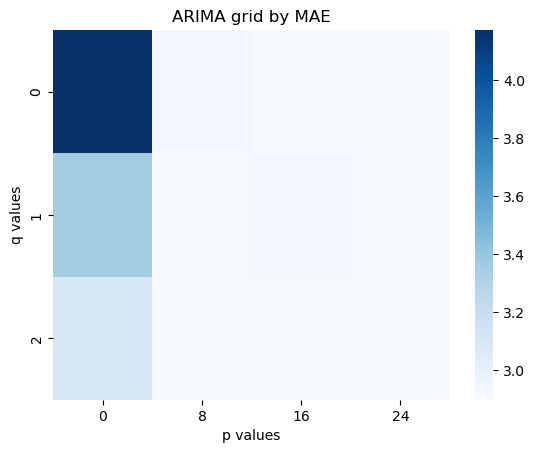

In [10]:
sns.heatmap(mae_df, cmap="Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARIMA grid by MAE");

### Model Diagnostics

Use the `plot_diagnostics()` method to evaluate the **residuals** of your ARIMA model.  
Make sure to call this method on your **best-performing model**, as the plot will display the residuals from the **last model trained**.

This diagnostic plot helps check:
- Whether the residuals are **normally distributed**  
- Whether there’s any **autocorrelation** left in the residuals  
- Overall **model fit quality**


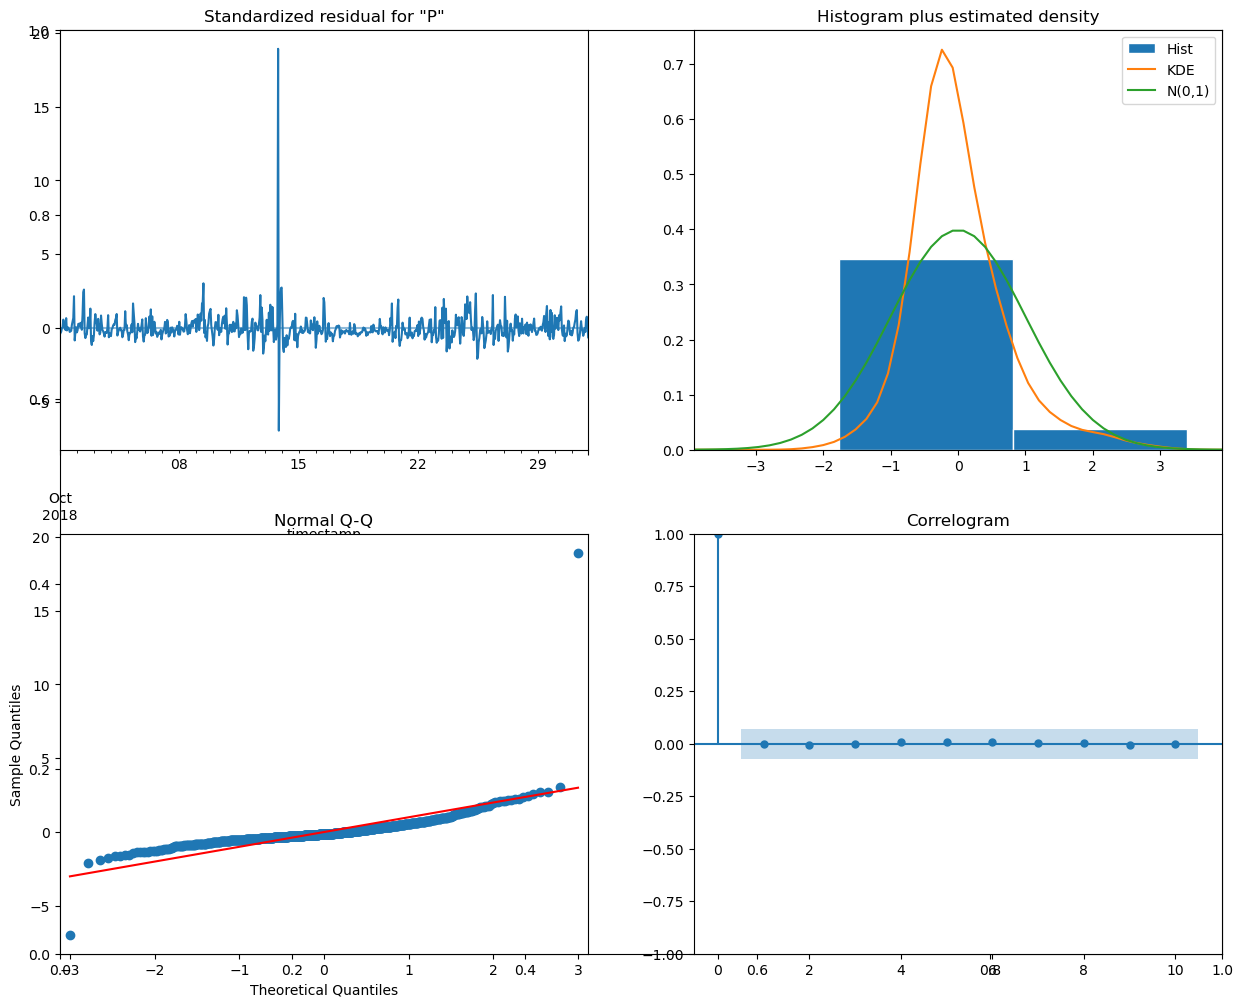

In [11]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

## Evaluate

### Walk-Forward Validation

Perform walk-forward validation for your model using the entire test set `y_test`.  
Store the model's predictions in a Series named `y_pred_wfv`.

Choose the values for **p** and **q** that best balance model performance and computation time.  
Keep in mind that this validation method will train the model **24 times** before you can calculate the final test **MAE**.


In [19]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()
y_pred_wfv = pd.Series(dtype=float)
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(8, 0, 1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test[next_pred.index]])

In [20]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.67


# Communicate Results

### Generating Predictions and Visualizing Results

1. **Generate Training Predictions**  
   - Use your model to generate a list of training predictions.

2. **Create the Results DataFrame**  
   - Combine the true values `y_test` and your predictions `y_pred_wfv` into a new DataFrame named `df_predictions`.  
   - Don’t forget to include the **index** so that both Series align correctly over time.

3. **Visualize with Plotly Express**  
   - Plot `df_predictions` using **Plotly Express (`px.line`)** to compare actual and predicted values.  
   - Label the **y-axis** as `"P2"` to represent PM2.5 readings.

This visualization helps you assess how well your model captures trends in the test data.



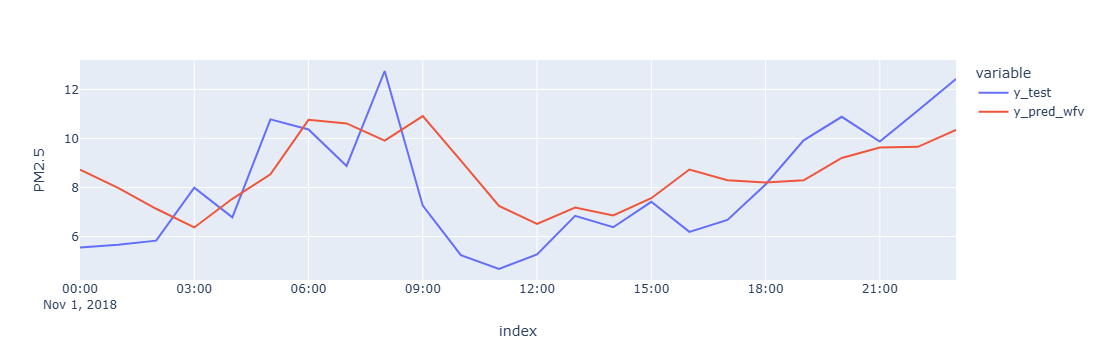

In [23]:
df_predictions = pd.DataFrame({
    "y_test":y_test,
    "y_pred_wfv":y_pred_wfv
})
fig = px.line(df_predictions,labels={"value":"PM2.5"})
fig.show();

## 🏁 Project Summary and Key Takeaways

In this project, we built and evaluated a **time series forecasting model** to predict **PM2.5 air quality readings** over time.

---

### 🧹 Data Preparation  
- Cleaned and preprocessed timestamped PM2.5 data.  
- Localized timestamps to the **Africa/Nairobi** timezone and handled missing values with **forward filling**.

---

### ⏱️ Feature Engineering  
- Created **lag-based features** to capture hourly dependencies in the time series.

---

### 📊 Modeling and Evaluation  
- Trained an **ARIMA (8, 0, 1)** model and optimized hyperparameters (`p`, `q`).  
- Evaluated model performance using **Mean Absolute Error (MAE)** on training and test sets.

---

### 🔁 Walk-Forward Validation  
- Implemented **walk-forward validation** to simulate real-time forecasting and confirm model adaptability.

---

### 📈 Visualization and Insights  
- Used **Plotly Express** to compare **actual vs. predicted** PM2.5 levels interactively.  
- Visualized forecasting accuracy and identified where the model aligned or diverged from real data.

---

### 💡 Conclusion  
This project demonstrates an end-to-end **time series forecasting workflow** — from **data cleaning** to **model evaluation and visualization**, showcasing strong skills in **predictive analytics** and **model interpretation**.
